In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from mpmath import *
from sympy import *
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from random import randint, uniform

In [2]:
from matplotlib.pyplot import figure
from numpy.random import randint
from sklearn.metrics import accuracy_score

In [3]:
normalization = 255
width = 28
heigth = 28

In [4]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [5]:
def normalize(X):
    return X / normalization

In [6]:
def denormalize(X):
    return X * normalization

In [7]:
def to_image_shape(X):
    return np.array(X).reshape(-1, width, heigth)

In [8]:
def to_vector_shape(X):
    return np.array(X).reshape(-1, width * heigth)

In [9]:
def show_samples(X, nrows=5, ncols=5, rsize=5, csize=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': -0.02, 'wspace': -0.02}, figsize=(rsize, csize))

    counter=0
    for row in ax:
        for col in row:
            col.imshow(X[counter], 'gray')
            col.axis('off')
            counter += 1
    plt.show()

In [10]:
def get_images_path(img_dir):
    """
    returns array with images path
    """
    image_full_names = []    
    image_names = listdir(img_dir)
    for image_name in image_names:
        image_full_names.append(img_dir + image_name)
    return image_full_names

In [11]:
def resize_images(images_path, width):
    """
    resize all images in the dataset for processing in format:
    N x M x 3  
    Width x Length x RGB
    """
    imported_images = []
    for image_path in images_path:
        foo = cv2.imread(image_path)
        foo = cv2.resize(foo, (image_width, width))
        imported_images.append(foo)
    return imported_images

In [12]:
def process_image(image, width):
    """
    returns image as an array of features
    """
    out = []
    for x in range(width):
        for y in range(width):
            for z in range(3): #account for RGB
                out.append(image[x][y][z])
    return np.asarray(out)

In [13]:
def precess_images(images, width):
    """
    returns numpy array of processed images
    """
    return np.array([process_image(image, width = width) for image in images])

In [44]:
import numpy as np

class Randomization():
    def __init__(self, resize_range=(5,5), pad_range=(0,1), w=28, h=28):
        self.default_w = w
        self.default_h = h
        self.resize_min = resize_range[0]
        self.resize_max = resize_range[1]
        self.pad_min = pad_range[0]
        self.pad_max = pad_range[1]
    
    def get_defended(self, X):
        return self.__random_resize_paddding(X)
    
    def __random_resize_paddding(self, X):
        X_new = np.zeros(X.shape)

        for idx, x in enumerate(X):
            default_w, default_h = (28, 28)

            w, h = np.random.randint(self.resize_min, self.resize_max, 2)
            if self.pad_min == 0:
                p_t, p_b, p_l, p_r = (0, 0, 0, 0)
            else:
                p_t, p_b, p_l, p_r = np.random.randint(self.pad_min, self.pad_max, 4)

            
            x_scaled = self.__scale(x, default_w + w, default_h + h)
            x_scaled_padded = np.pad(x_scaled, ((p_t, p_b), (p_l, p_r)), 'constant')
            x_normal = self.__scale(x_scaled_padded, default_w, default_h)

            X_new[idx] = x_normal    
        return X_new

    def __scale(self, img, n_rows, n_cols):
        n_rows0 = img.shape[0]
        n_cols0 = img.shape[1]
        new_img = np.zeros((n_rows, n_cols))

        r_idxs = (n_rows0 * np.arange(n_rows) / n_rows).astype(int)
        c_idxs = (n_cols0 * np.arange(n_cols) / n_cols).astype(int)
        for i, r_idx in enumerate(r_idxs):
            for j, c_idx in enumerate(c_idxs):
                new_img[i][j] = img[r_idx][c_idx]

        return new_img

In [15]:
class PixelDeflection():
    def __init__(self, deflections=10, window=10):
        self.deflections = deflections
        self.window = window

    def get_defended(self, X, rmap=None):
        if rmap != None:
            X_new = [
                self.pixel_deflection_with_map(x, rcam_prob, self.deflections, self.window) for x in X
            ] 
        else:
            X_new = [
                self.pixel_deflection_without_map(x, self.deflections, self.window) for x in X
            ]
            
        return X_new
    
    def pixel_deflection_without_map(self, img, deflections, window):
        img = np.copy(img)
        H, W = img.shape
        while deflections > 0:
                x,y = randint(0,H-1), randint(0,W-1)
                while True: #this is to ensure that PD pixel lies inside the image
                    a,b = randint(-1*window,window), randint(-1*window,window)
                    if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
                # calling pixel deflection as pixel swap would be a misnomer,
                # as we can see below, it is one way copy
                img[x,y] = img[x+a,y+b] 
                deflections -= 1
        return img
    
    def pixel_deflection_with_map(self, img, rcam_prob, deflections, window):
        img = np.copy(img)
        H, W = img.shape
        while deflections > 0:
                x,y = randint(0,H-1), randint(0,W-1)
                # if a uniformly selected value is lower than the rcam probability
                # skip that region
                if uniform(0,1) < rcam_prob[x,y]:
                    continue

                while True: #this is to ensure that PD pixel lies inside the image
                    a,b = randint(-1*window,window), randint(-1*window,window)
                    if x+a < H and x+a > 0 and y+b < W and y+b > 0: break

                # calling pixel deflection as pixel swap would be a misnomer,
                # as we can see below, it is one way copy
                img[x,y] = img[x+a,y+b] 
                deflections -= 1
        return img

In [68]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
X = X.to_numpy()
y = y.to_numpy()
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


In [70]:
X_test_images = to_image_shape(X_test)

#### Show images

In [19]:
# X_show = X_train.to_numpy().reshape(-1,28,28)
# show_samples(X_show, nrows=8, ncols=8, rsize=10, csize=10)

#### One Hot Encoding

In [71]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

# encoder.fit(y_test)
# Y_test = encoder.transform(y_test).toarray()

#### Model Training

0 iteration: 98.68221827117337


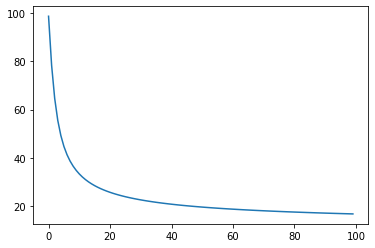

16.78538222598934
Wall time: 7.58 s


In [72]:
%%time
from LogisticRegression import CustomLogisticRegression
lg = CustomLogisticRegression(normalize=False)
lg.fit(normalize(X_train), Y_train, 0.5, 100, 1e-15)

plot_J(lg.get_cost_history())
print(lg.get_cost_history()[-1])

#### Prediction

In [73]:
y_pred = lg.predict(normalize(X_test))
accuracy_score(y_pred, y_test)

0.8952380952380953

#### Import

In [74]:
from attacks import *
from defenses import *

from benchmark import untargeted_attack_benchmark
from benchmark import show_adversarial_sample
from benchmark import benchmark_models

### Benchmark

In [75]:
# %%time
# defense_random = Randomization(resize_range=(-3, 3), pad_range=(0, 0))
# X_test_randomized = to_vector_shape(defense_random.get_defended(X_test_images))
# y_pred_randomized = lg.predict(normalize(X_test_randomized))
# accuracy_score(y_test, y_pred_randomized)

Wall time: 11.7 s


0.7330952380952381

0.8932142857142857
Wall time: 17.5 s


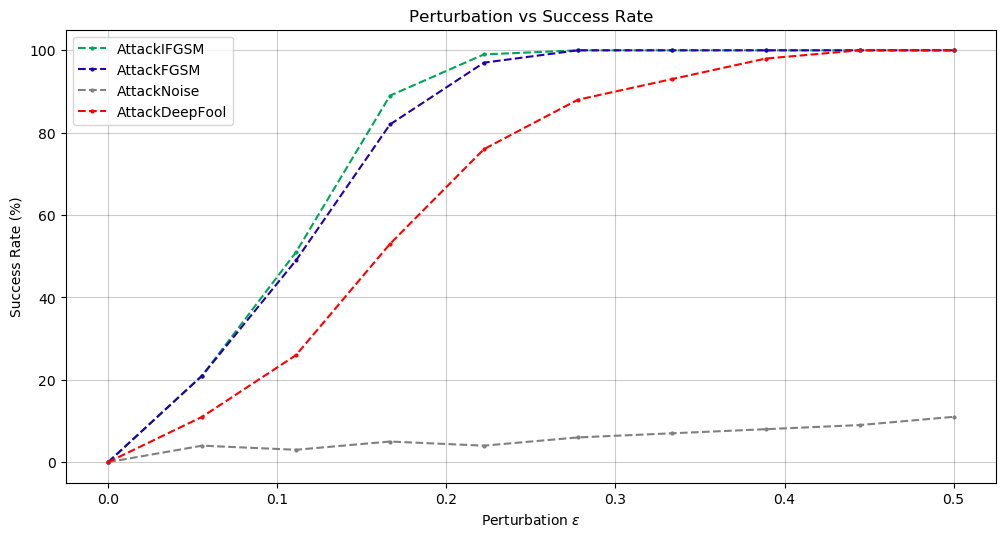

In [99]:
%%time
defense_deflection = PixelDeflection(deflections=20, window=10)
X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images))
y_pred_deflected = lg.predict(normalize(X_test_deflected))
print(accuracy_score(y_test, y_pred_deflected))

correct_pred_idx = y_test[:, 0] == y_pred_deflected
benchmark_models(X_test_deflected, y_labels, lg, num_steps=10)

In [90]:
# correct_pred_idx = y_test[:, 0] == y_pred_randomized
# benchmark_models(X_test_randomized[correct_pred_idx], y_labels, lg, num_steps=10)

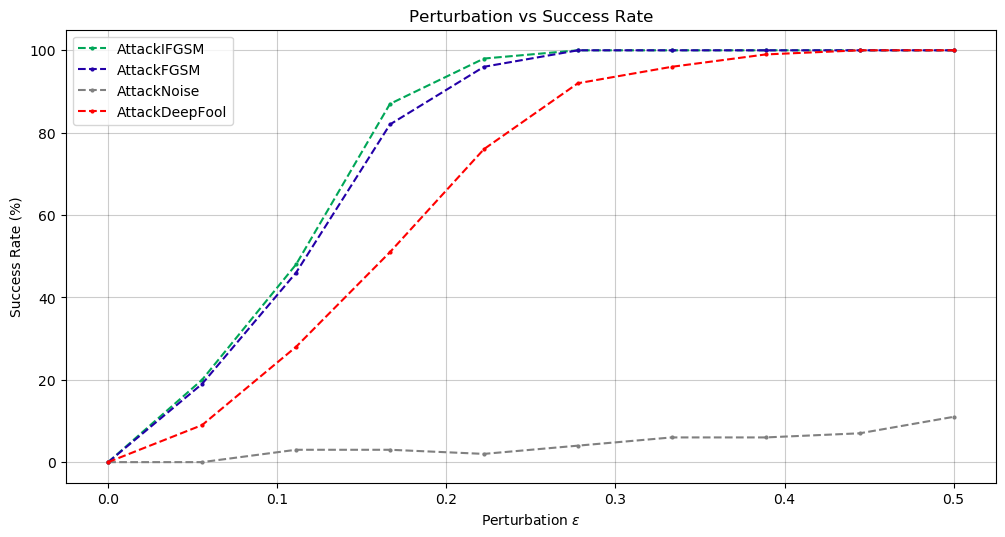

In [100]:
correct_pred_idx = y_test[:, 0] == y_pred
benchmark_models(X_test, y_labels, lg, num_steps=10)

#### RMAP

In [ ]:
# X_test.iloc[0, :].shape

# avg = 0
# for i in range(X_test.shape[0]):
#     attack = AttackFGSM()
#     x_ = normalize(np.expand_dims(X_test.iloc[i, :], axis=0))
#     a = attack.attack(x_, lg.W, lg.b, y, lg.predict, max_norm=1)
#     avg = avg + (x_ - a)
    

In [ ]:
# #avg = avg / X_test.shape[0]
# #plt.imshow(avg.reshape(28, 28))
# #avg
# denormalize(avg) / X_test.shape[0]
# rmap = abs((avg / X_test.shape[0]).reshape(28, 28))
# plt.imshow(rmap, 'gray')
# rmap[15]

In [ ]:
# x_ = X_test.to_numpy().reshape(-1, 28,28)[0]
# res = pixel_deflection_with_map(x_, avg.reshape(-28, 28), 100, 20)
# plt.imshow(res)

In [ ]:
# avg = avg / X_test.shape[0]
# plt.imshow(avg.reshape(28, 28))

### Untargeted Noise Attack

In [ ]:
# index = 38
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_norm=1)

### Untargeted FGSM

In [ ]:
# index = 0
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_norm=0.07)

### Untargeted I-FGSM

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.04, max_iters=100)

### DeepFool

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.15, max_iters=12)

### Targeted I-FGSM

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))
# y[9] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_norm=0.2, max_iters=5000)

### Untargeted MI-FGSM

In [ ]:
# index = 123
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackMIFGSM, max_norm=1, max_iters=5000)

#### Model evaluation

In [ ]:
# y_real = np.array(y_test.iloc[:, 0])

# comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
# print(comp.head(20))

In [ ]:
##### from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# r2 = r2_score(y_real, y_pred)
# accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)

# print(f'Coefficient of determination: {r2}')
# print(f"Accuracy: {accuracy}%")